In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,roc_curve, auc, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import adam_v2
from livelossplot import PlotLossesKeras
from keras.utils import np_utils
from joblib import load, dump

## Import All the datasets

In [2]:
#original complete data, cleaned

traincomplete = pd.read_csv("datasets/cleaned/traindata.csv")
testcomplete = pd.read_csv("datasets/cleaned/testdata.csv")

#feature selection data

trainfeatureselection = pd.read_csv("datasets/featureselection/train.csv")
testfeatureselection = pd.read_csv("datasets/featureselection/test.csv")

#dimensionality reduction data for PCA - RF, PCA - SVC, LDA

#RandomForestPCA
trainpcarf = pd.read_csv("datasets/dimreduction/trainrf.csv")
testpcarf = pd.read_csv("datasets/dimreduction/testrf.csv")

#SupportVectorClassifierPCA
trainpcasvc = pd.read_csv("datasets/dimreduction/trainsvc.csv")
testpcasvc = pd.read_csv("datasets/dimreduction/testsvc.csv")

#LDA
trainlda = pd.read_csv("datasets/dimreduction/trainlda.csv")
testlda = pd.read_csv("datasets/dimreduction/testlda.csv")

## Preprocessing

1. Set sample_id as index
2. Partition in X and Y: Since the train test split was only done in week 1, same trainlabels and testlabels can be used for all datasets
3. Standardization : Only complete data and feature selection data need to be standardize, dim reduction data is already standardized

In [3]:
traincomplete.set_index("sample_id", inplace = True)
testcomplete.set_index("sample_id", inplace = True)

trainfeatureselection.set_index("sample_id", inplace = True)
testfeatureselection.set_index("sample_id", inplace = True)

In [4]:

Xtraincomplete = traincomplete.drop(columns=['Class'])
Xtestcomplete = testcomplete.drop(columns = ['Class'])

labelsTrain = traincomplete['Class']
labelsTest = testcomplete['Class']

Xtrainfeature = trainfeatureselection.drop(columns=['Class'])
Xtestfeature = testfeatureselection.drop(columns=['Class'])

Xtrainpcarf = trainpcarf.drop(columns=['Class'])
Xtestpcarf = testpcarf.drop(columns=['Class'])

Xtrainpcasvc =trainpcasvc.drop(columns=['Class'])
Xtestpcasvc =testpcasvc.drop(columns=['Class'])

Xtrainlda = trainlda.drop(columns=['Class'])
Xtestlda = testlda.drop(columns=['Class'])

In [5]:
def plot_roc_auc_curves_and_confusion_matrix(y_test, y_score, matrix):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    for i in range(5):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve class {i} (area = {roc_auc[i]})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend()
    plt.subplot(1,2,2)
    sns.heatmap(matrix,annot=True,cmap ="PuBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

In [18]:
def calculate_average_roc_auc_score_and_plot_curves(Xtrain, Xtest, Ytrain, Ytest, model, standardize = True):
    std = StandardScaler()
    if(standardize):
        Xtrainfit = std.fit_transform(Xtrain)
        Xtestfit = std.transform(Xtest)
    else:
        Xtrainfit = Xtrain.copy()
        Xtestfit = Xtest.copy()
    model.fit(Xtrainfit,Ytrain)
    Ytestbinary = label_binarize(Ytest,classes=[0,1,2,3,4])
    Ypred = model.predict(Xtestfit)
    Yscore = model.predict_proba(Xtestfit)
    matrix = confusion_matrix(Ytest,Ypred)
    score = roc_auc_score(Ytestbinary,Yscore, average='weighted', multi_class='ovr')
    plot_roc_auc_curves_and_confusion_matrix(Ytestbinary,Yscore, matrix)
    return score

In [7]:
scores_df = pd.DataFrame({"Model Family":[], "Dataset" : [], "ROC_AUC_SCORE" : [], "Best Params": []})

In [8]:
def add_to_df(model_family,dataset_name,roc_score, best_params):
    global scores_df
    dic = {"Model Family": [model_family], "Dataset" : [dataset_name], "ROC_AUC_SCORE" :[roc_score], 
           "Best Params":[best_params]}
    df = pd.DataFrame(dic)
    scores_df = pd.concat([scores_df,df],axis=0,)

In [9]:
random_state = 10

# RandomForest Models

In [10]:
kfrf = StratifiedKFold(n_splits=5)
piperf = Pipeline([('standardize', StandardScaler()), ('rf', RandomForestClassifier(random_state=random_state))])

## On Complete Dataset

In [11]:
try:
    gridrfcomplete = load("week4/models/gridrfcomplete.joblib")
    
except:
    params_grid_rf_complete = {'rf__n_estimators' : [500,1000,2000], 
                               'rf__max_features' : ['sqrt', 'log2'], 'rf__criterion': ['gini', 'entropy']}
    gridrfcomplete = GridSearchCV(piperf,params_grid_rf_complete,scoring='accuracy',cv=kfrf)
    gridrfcomplete.fit(Xtraincomplete,labelsTrain)
    dump(gridrfcomplete, "week4/models/gridrfcomplete.joblib")

In [12]:
print(gridrfcomplete.best_score_)

0.9955882352941178


In [15]:
gridrfcomplete.best_params_

{'rf__criterion': 'gini', 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}

In [16]:
rf_model_complete = RandomForestClassifier(n_estimators=500, criterion='gini',
                                           max_features='sqrt', random_state=random_state)

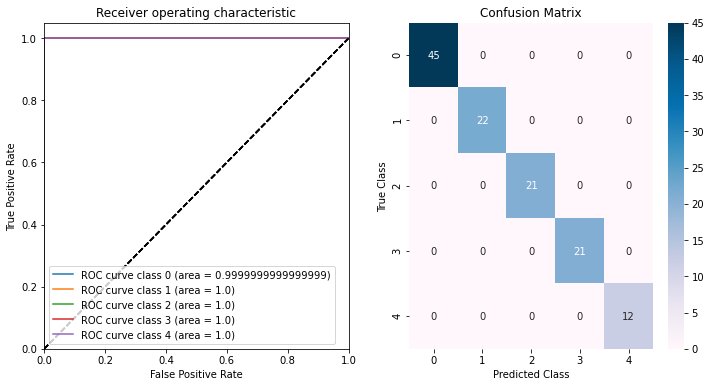

In [19]:
rfcompletescore = calculate_average_roc_auc_score_and_plot_curves(Xtraincomplete,Xtestcomplete,
                                                                  labelsTrain, labelsTest,rf_model_complete)

In [20]:
print(rfcompletescore)
add_to_df("Random Forest", "Complete", rfcompletescore, best_params_rf_complete)

1.0


## On Feature Selection Dataset

In [21]:
try:
    gridrffeature = load("week4/models/gridrffeature.joblib")

except:

    params_grid_rf_feature = {'rf__n_estimators' : [50,100,200,400], 
                               'rf__max_features' : ['sqrt', 'log2'], 'rf__criterion': ['gini', 'entropy']}
    gridrffeature = GridSearchCV(piperf,params_grid_rf_feature,scoring='accuracy',cv=kfrf)
    gridrffeature.fit(Xtrainfeature,labelsTrain)
    dump(gridrffeature, "week4/models/gridrffeature.joblib")

In [22]:
print(gridrffeature.best_score_)

1.0


In [23]:
gridrffeature.best_params_

{'rf__criterion': 'entropy',
 'rf__max_features': 'log2',
 'rf__n_estimators': 50}

In [24]:
rf_model_feature = RandomForestClassifier(n_estimators=50, criterion='entropy', 
                                          max_features='log2', random_state = random_state)

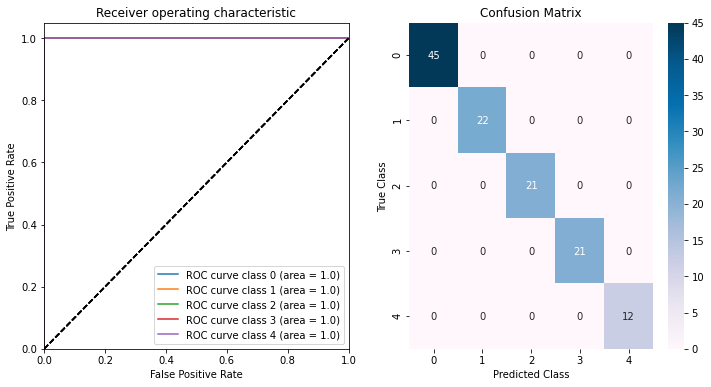

In [25]:
rffeaturescore = calculate_average_roc_auc_score_and_plot_curves(Xtrainfeature,Xtestfeature,
                                                                 labelsTrain,labelsTest,rf_model_feature)

In [27]:
print(rffeaturescore)
add_to_df("Random Forest", "Feature Selection", rffeaturescore, gridrffeature.best_params_)

1.0


## On PCA Dataset

In [28]:
try:
    gridrfpca = load("week4/models/gridrfpca.joblib")

except:

    params_grid_rf_pca = {'n_estimators' : [50,100,150,200], 
                               'max_features' : ['sqrt', 'log2'], 'criterion': ['gini', 'entropy']}
    gridrfpca = GridSearchCV(RandomForestClassifier(random_state=random_state),params_grid_rf_pca,
                             scoring='accuracy',cv=kfrf)
    gridrfpca.fit(Xtrainpcarf,labelsTrain)
    dump(gridrfpca, "week4/models/gridrfpca.joblib")

In [29]:
print(gridrfpca.best_score_)

0.9838235294117647


In [30]:
best_params_rf_pca = gridrfpca.best_params_
rf_model_pca = RandomForestClassifier(**best_params_rf_pca, random_state = random_state)

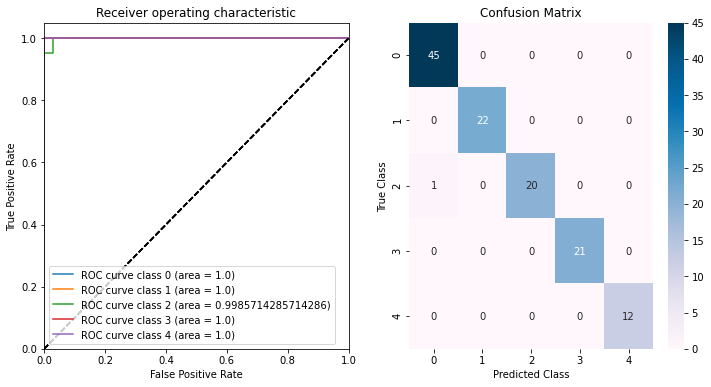

In [31]:
rfpcascore = calculate_average_roc_auc_score_and_plot_curves(Xtrainpcarf,Xtestpcarf,
                                                             labelsTrain,labelsTest,rf_model_pca,standardize=False)

In [32]:
print(rfpcascore)
add_to_df("Random Forest", "PCA", rfpcascore, best_params_rf_pca)

0.9997520661157024


## On LDA Dataset

In [34]:
try:
    gridrflda = load("week4/models/gridrflda.joblib")

except:

    params_grid_rf_lda = {'n_estimators' : [25,50,100,200], 
                               'max_features' : ['sqrt', 'log2'], 'criterion': ['gini', 'entropy']}
    gridrflda = GridSearchCV(RandomForestClassifier(random_state=10),params_grid_rf_lda,scoring='accuracy',cv=kfrf)
    gridrflda.fit(Xtrainlda,labelsTrain)
    dump(gridrflda, "week4/models/gridrflda.joblib")

In [35]:
print(gridrflda.best_score_)

1.0


In [36]:
best_params_rf_lda = gridrfpca.best_params_
rf_model_lda = RandomForestClassifier(**best_params_rf_lda)

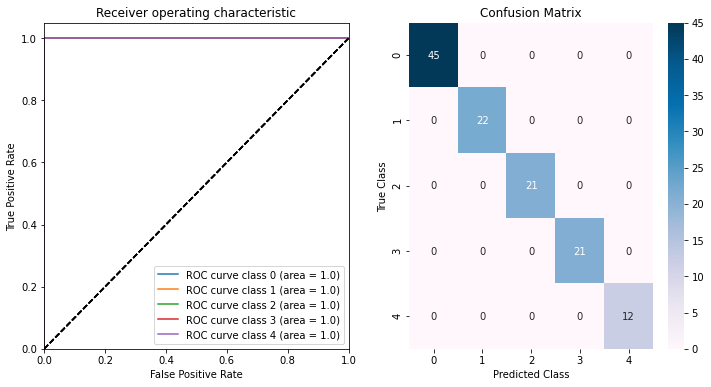

In [37]:
rfldascore = calculate_average_roc_auc_score_and_plot_curves(Xtrainlda,Xtestlda,
                                                             labelsTrain,labelsTest,rf_model_lda,standardize=False)

In [38]:
print(rfldascore)
add_to_df("Random Forest", "LDA", rfldascore, best_params_rf_lda)

1.0


# Support Vector Classifiers Models

In [40]:
kfsvc = StratifiedKFold(n_splits=5)
pipesvc = Pipeline([('standardize', StandardScaler()), ('svc', SVC(random_state=random_state))])

## On Complete Dataset

In [41]:
try:
    gridsvccomplete = load("week4/models/gridsvccomplete.joblib")
    
except:
    params_grid_svc_complete = {'svc__C' : [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1], 
                               'svc__kernel' : ['linear']}
    gridsvccomplete = GridSearchCV(pipesvc,params_grid_svc_complete,scoring='accuracy',cv=kfsvc)
    gridsvccomplete.fit(Xtraincomplete,labelsTrain)
    dump(gridsvccomplete, "week4/models/gridsvccomplete.joblib")

In [42]:
print(gridsvccomplete.best_score_)

0.9985294117647058


In [44]:
best_params_svc_complete = gridsvccomplete.best_params_
print(best_params_svc_complete)

{'svc__C': 5e-05, 'svc__kernel': 'linear'}


In [47]:
svc_model_complete = SVC(C = 0.00005, kernel='linear', probability = True, random_state=random_state)

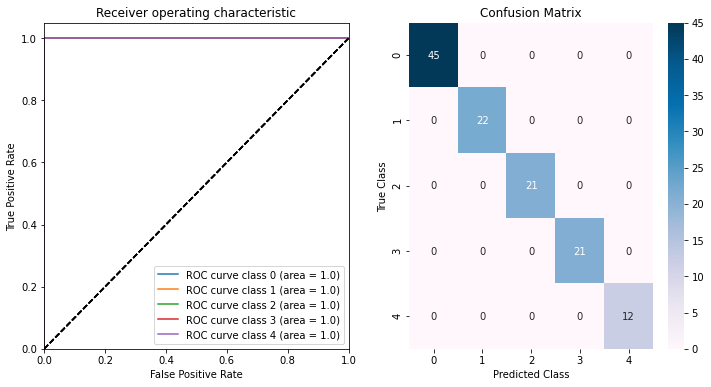

In [48]:
svccompletescore = calculate_average_roc_auc_score_and_plot_curves(Xtraincomplete,Xtestcomplete,
                                                                   labelsTrain,labelsTest,svc_model_complete)

In [49]:
print(svccompletescore)
add_to_df("Support Vector Classifier", "Complete", svccompletescore, best_params_svc_complete)

1.0


## On Feature Selection Dataset

In [52]:
try:
    gridsvcfeature = load("week4/models/gridsvcfeature.joblib")
    
except:
    params_grid_svc_feature = {'svc__C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
                               'svc__kernel' : ['linear','rbf','poly'], 'svc__degree' : [2,3,4,5]}
    gridsvcfeature = GridSearchCV(pipesvc,params_grid_svc_feature,scoring='accuracy',cv=kfsvc)
    gridsvcfeature.fit(Xtrainfeature,labelsTrain)
    dump(gridsvcfeature, "week4/models/gridsvcfeature.joblib")

In [53]:
print(gridsvcfeature.best_score_)

1.0


In [54]:
best_params_svc_feature = gridsvcfeature.best_params_
print(best_params_svc_feature)

{'svc__C': 0.01, 'svc__degree': 2, 'svc__kernel': 'linear'}


In [55]:
svc_model_feature = SVC(C=0.01, kernel = 'linear', probability = True, random_state=random_state)

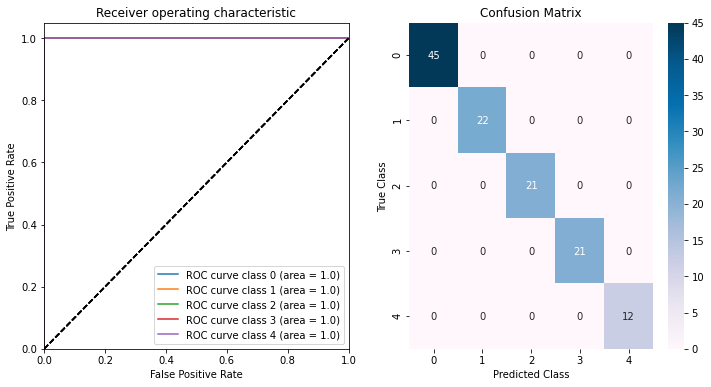

In [56]:
svcfeaturescore = calculate_average_roc_auc_score_and_plot_curves(Xtrainfeature,Xtestfeature,
                                                                  labelsTrain,labelsTest,svc_model_feature)

In [57]:
print(svcfeaturescore)
add_to_df("Support Vector Classifier", "Feature Selection", svcfeaturescore, best_params_svc_feature)

1.0


## On PCA Dataset

In [59]:
try:
    gridsvcpca = load("week4/models/gridsvcpca.joblib")
    
except:
    params_grid_svc_pca = {'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
                               'kernel' : ['linear','rbf','poly'], 'degree' : [2,3,4,5]}
    gridsvcpca = GridSearchCV(SVC(random_state=random_state),params_grid_svc_pca, scoring='accuracy',cv=kfsvc)
    gridsvcpca.fit(Xtrainpcasvc,labelsTrain)
    dump(gridsvcpca, "week4/models/gridsvcpca.joblib")

In [60]:
print(gridsvcpca.best_score_)

1.0


In [61]:
best_params_svc_pca = gridsvcpca.best_params_
print(best_params_svc_pca)
svc_model_pca = SVC(**best_params_svc_pca, probability=True,random_state=random_state)

{'C': 0.0001, 'degree': 2, 'kernel': 'linear'}


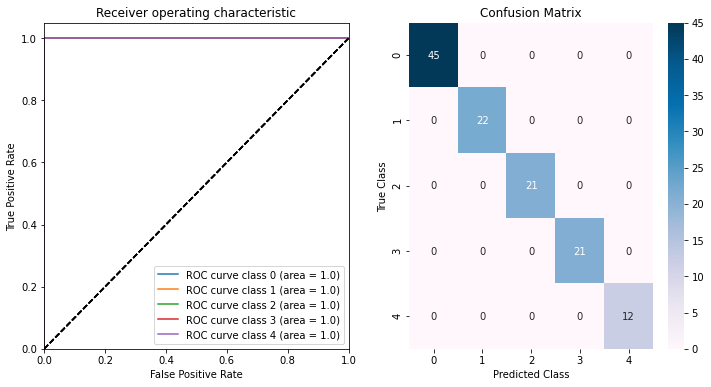

In [62]:
svcpcascore = calculate_average_roc_auc_score_and_plot_curves(Xtrainpcasvc,Xtestpcasvc,labelsTrain,labelsTest,
                                                              svc_model_pca,standardize=False)

In [63]:
print(svcpcascore)
add_to_df("Support Vector Classifier", "PCA", svcpcascore, best_params_svc_pca)

1.0


## On LDA Dataset

In [68]:
try:
    gridsvclda = load("week4/models/gridsvclda.joblib")
    
except:
    params_grid_svc_pca = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
                               'kernel' : ['linear','rbf','poly'], 'degree' : [2,3,4,5]}
    gridsvclda = GridSearchCV(SVC(random_state=10),params_grid_svc_pca, scoring='accuracy',cv=kfsvc)
    gridsvclda.fit(Xtrainlda,labelsTrain)
    dump(gridsvclda, "week4/models/gridsvclda.joblib")

In [69]:
print(gridsvclda.best_score_)

0.9985294117647058


In [70]:
best_params_svc_lda = gridsvclda.best_params_
print(best_params_svc_lda)
svc_model_lda = SVC(**best_params_svc_lda, random_state=10, probability=True)

{'C': 0.001, 'degree': 2, 'kernel': 'linear'}


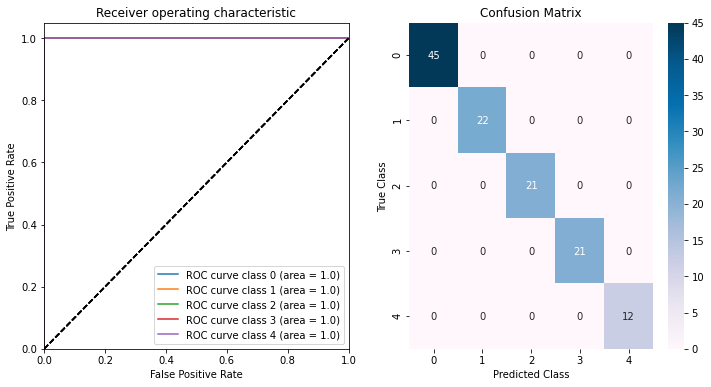

In [71]:
svcldascore = calculate_average_roc_auc_score_and_plot_curves(Xtrainlda,Xtestlda,labelsTrain,labelsTest,
                                                              svc_model_lda, standardize=False)

In [72]:
print(svcldascore)
add_to_df("Support Vector Classifier", "LDA", svcldascore, best_params_svc_lda)

1.0


In [106]:
scores_df.to_csv("week4/results.csv", index=False)